# Wasserstein distance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def np_to_df(data, columns=None):
    return pd.DataFrame(data, columns=columns)

def concat_with_assign(dfs, assignments, column="label"):
    return pd.concat([df.assign(**{column: assignment}) for df, assignment in zip(dfs, assignments)], ignore_index=True)

def cartesian(axes):
    return np.stack(np.meshgrid(*axes), -1).reshape(-1, len(axes))

In [3]:
def kdeplot(p, q, alpha=1.0, fill=True):
    if p.shape[1] != q.shape[1]:
        raise ValueError("p and q dimensions should be equal")
    
    ndim = p.shape[1]
    if ndim not in [1, 2]:
        raise ValueError("Can only plot in 1 or 2 dimensions")
    
    columns = [str(i) for i in range(ndim)]
    label_column = "label"
    p_df = np_to_df(p, columns=columns)
    q_df = np_to_df(q, columns=columns)
    dfs = concat_with_assign([p_df, q_df], ["p", "q"], column=label_column)
    
    if ndim == 1:
        sns.kdeplot(data=dfs, x="0", hue=label_column, alpha=alpha, fill=fill)
        plt.xlabel("x")
        plt.ylabel("density")
    else:
        sns.kdeplot(data=dfs, x="0", y="1", hue=label_column, alpha=alpha, fill=fill)
        plt.xlabel("x")
        plt.ylabel("y")
    plt.tight_layout()
        
def histplot(p_hist, p_centers, q_hist, q_centers, alpha=1.0, fill=True):
    if len(p_hist.shape) != len(q_hist.shape):
        raise ValueError("p and q dimensions should be equal")
        
    ndim = len(p_hist.shape)
    if ndim not in [1, 2]:
        raise ValueError("Can only plot in 1 or 2 dimensions")
        
    p_bins, q_bins = p_hist.shape[0], q_hist.shape[0]
    if ndim == 1:
        sns.histplot(x=p_centers.flatten(), weights=p_hist, bins=bins, color="C0", alpha=alpha, label="p")
        sns.histplot(x=q_centers.flatten(), weights=q_hist, bins=bins, color="C1", alpha=alpha, label="q")
        plt.xlabel("x")
        plt.ylabel("count")
    else:
        sns.histplot(x=p_centers[:, 0], y=p_centers[:, 1], weights=p_hist.flatten(), bins=bins, color="C0", alpha=alpha, label="p")
        sns.histplot(x=q_centers[:, 0], y=q_centers[:, 1], weights=q_hist.flatten(), bins=bins, color="C1", alpha=alpha, label="q")
        plt.xlabel("x")
        plt.ylabel("y")
    plt.legend()
    plt.tight_layout()

### Distributions

In [4]:
ndim = 2
n = 1000
alpha = 0.5

In [5]:
p = np.random.multivariate_normal([0] * ndim, np.diag([1.0] * ndim), n)
q = np.random.multivariate_normal([0] * ndim, np.diag([1.0] * ndim), n)

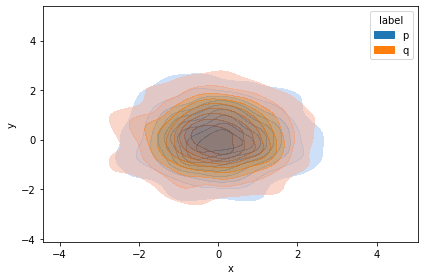

In [6]:
kdeplot(p, q, alpha=alpha)

### POT

##### Histograms

In [7]:
bins = 100

In [8]:
p_hist, p_edges = np.histogramdd(p, bins=bins, density=True)
p_hist = p_hist / p_hist.sum()
p_centers = cartesian([dim_edges[:-1] + np.diff(dim_edges)/2 for dim_edges in p_edges])
q_hist, q_edges = np.histogramdd(q, bins=bins, density=True)
q_hist = q_hist / q_hist.sum()
q_centers = cartesian([dim_edges[:-1] + np.diff(dim_edges)/2 for dim_edges in q_edges])

No handles with labels found to put in legend.


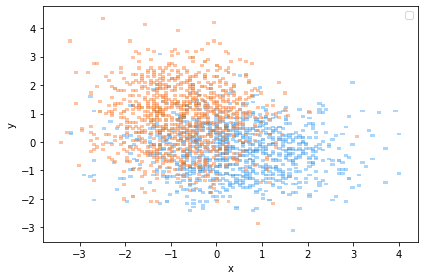

In [9]:
histplot(p_hist, p_centers, q_hist, q_centers, alpha)

### Geomloss

In [10]:
import pykeops
import torch
from geomloss import SamplesLoss
pykeops.gpu_available = False

In [11]:
Loss = SamplesLoss("sinkhorn", p=2, blur=.005, scaling=.9)

In [12]:
dist = Loss(torch.from_numpy(p), torch.from_numpy(q)).item()
print("Wasserstein distance: ", dist)

Wasserstein distance:  0.021613683567115495


##### Different q means

In [13]:
ndim = 2
n = 100
means = np.linspace(-10, 10, 100)
Loss = SamplesLoss("sinkhorn", p=1, blur=0.05, scaling=0.7)

p = np.random.multivariate_normal([0] * ndim, np.diag([1] * ndim), n)
distances = []

for mean in means:
    q = np.random.multivariate_normal([mean] * ndim, np.diag([1] * ndim), n)
    
    distances.append(Loss(torch.from_numpy(p), torch.from_numpy(q)).item())

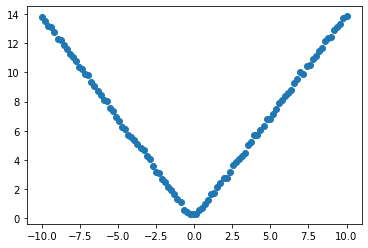

In [14]:
_ = plt.scatter(means, distances)